# Кластеризация текста

В качестве датасета для кластеризации возьмём [корпус](https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip) Твиттера

# 1. Загрузка данных

In [1]:
import pandas as pd
data = pd.read_csv('amazon_cells_labelled.txt', sep='\t', names=['text', 'label'])
X, y = data['text'], data['label']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

/home/artem/anaconda3/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# 2.1 Обучим SVM

In [2]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

model = Pipeline(
[
    ('vect', TfidfVectorizer()),
    ('svm', SVC(kernel='linear'))
])

model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [3]:
y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.865

# 2.2 Посмотрим на важность признаков

In [4]:
weights = model.steps[1][1].coef_.toarray()[0]
words = model.steps[0][1].get_feature_names()
coefs = pd.Series(index=words, data=weights)
coefs.sort_values()


not             -3.403966
first           -1.894592
poor            -1.863408
if              -1.539088
bad             -1.492231
disappointed    -1.361145
disappointing   -1.301748
hear            -1.286448
none            -1.277520
doesn           -1.268363
old             -1.244290
weak            -1.232634
don             -1.222313
terrible        -1.202271
then            -1.137920
worst           -1.111107
difficult       -1.068876
problem         -1.038385
buying          -1.022125
in              -1.003122
money           -0.988396
out             -0.988226
calls           -0.982871
plug            -0.962857
horrible        -0.959344
experience      -0.938431
off             -0.935631
crap            -0.931065
cheap           -0.919084
didn            -0.916439
                   ...   
even             0.983197
quite            0.985125
worthwhile       1.000000
again            1.016178
happy            1.045653
cell             1.046392
won              1.064681
definitely  

# 2.3 Визуализируем предсказания модели и твиты с помощью t-SNE

In [5]:
from sklearn.manifold import TSNE
from mlxtend.preprocessing import DenseTransformer

model = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('dense', DenseTransformer()),
    ('tsne', TSNE(n_components=2))
])

X_emb = model.fit_transform(X_test, y_test)

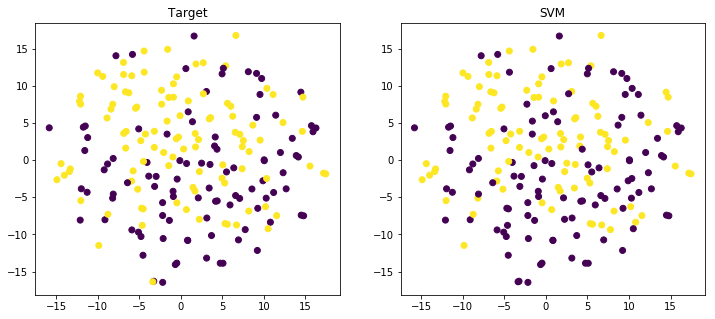

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Target')
plt.scatter(X_emb[:, 0], X_emb[:, 1], c=y_test)

plt.subplot(122)
plt.title('SVM')
plt.scatter(X_emb[:, 0], X_emb[:, 1], c=y_pred)

# 3.1 Обучим теперь KMeans и посмотрим, какие кластеры он выделит

In [10]:
from sklearn.cluster import KMeans

model = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('dense', DenseTransformer()),
    ('tsne', KMeans(n_clusters=2))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [13]:
for i in range(2):
    print(y_test[y_pred == i].mean(), y_test[y_pred == i].shape[0])

0.478494623655914 186
1.0 14


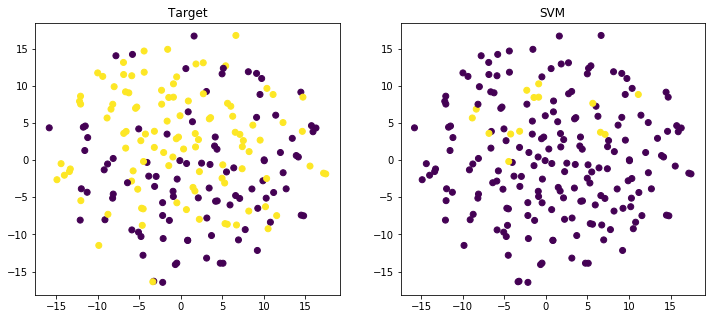

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Target')
plt.scatter(X_emb[:, 0], X_emb[:, 1], c=y_test)

plt.subplot(122)
plt.title('SVM')
plt.scatter(X_emb[:, 0], X_emb[:, 1], c=y_pred)

Видим, что кластера получились совсем не те, какие должны быть (kMeans выделил кластера из своих соображений, совсем не связанных с эмоциональной окрашенностью). Посмотрим, что будет, если мы увеличим число кластеров

In [14]:
from sklearn.cluster import KMeans

model = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('dense', DenseTransformer()),
    ('tsne', KMeans(n_clusters=10))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [18]:
for i in range(10):
    cluster_size = y_test[y_pred == i].shape[0]
    positives_cnt = y_test[y_pred == i].sum()
    negatives_cnt = cluster_size - positives_cnt
    print('Cluster number: %d, Cluster size: %d, Positive count: %d (%.2f%%), Negative count: %d (%.2f%%)' % 
          (i, cluster_size, positives_cnt, positives_cnt * 100./cluster_size, negatives_cnt, negatives_cnt * 100./cluster_size))

Cluster number: 0, Cluster size: 9, Positive count: 6 (66.67%), Negative count: 3 (33.33%)
Cluster number: 1, Cluster size: 68, Positive count: 34 (50.00%), Negative count: 34 (50.00%)
Cluster number: 2, Cluster size: 10, Positive count: 10 (100.00%), Negative count: 0 (0.00%)
Cluster number: 3, Cluster size: 13, Positive count: 13 (100.00%), Negative count: 0 (0.00%)
Cluster number: 4, Cluster size: 29, Positive count: 13 (44.83%), Negative count: 16 (55.17%)
Cluster number: 5, Cluster size: 16, Positive count: 5 (31.25%), Negative count: 11 (68.75%)
Cluster number: 6, Cluster size: 18, Positive count: 9 (50.00%), Negative count: 9 (50.00%)
Cluster number: 7, Cluster size: 21, Positive count: 9 (42.86%), Negative count: 12 (57.14%)
Cluster number: 8, Cluster size: 14, Positive count: 4 (28.57%), Negative count: 10 (71.43%)
Cluster number: 9, Cluster size: 2, Positive count: 0 (0.00%), Negative count: 2 (100.00%)


Видим, что теперь в некоторых кластерах нужное нам разделение произошло и в некоторых кластерах преобладают негативные комментарии, в некоторых - позитивные (а в некоторых поровну). Посмотрим на последний кластер

In [19]:
X_test[y_pred == 9]

268            Don't waste your money!.
9      What a waste of money and time!.
Name: text, dtype: object

In [20]:
X_test[y_pred == 8]

163    Works like a charm; it work the same as the on...
634    Not only did the software do a great job of th...
790                                   NOT WHAT I WANTED.
121                  Could not get strong enough signal.
997                         Item Does Not Match Picture.
828                                        Doesn't Work.
690    The nokia CA-42 USB cable did not work with my...
462      Cant get the software to work with my computer.
748                                        Does not fit.
73                Nice docking station for home or work.
610                   It doesn't work in Europe or Asia.
293                          DO NOT PURCHASE THIS PHONE.
933       Does not charge the Cingular (ATT) 8525 phone.
51     good protection and does not make phone too bu...
Name: text, dtype: object

Визуализируем кластеры с помощью t-SNE

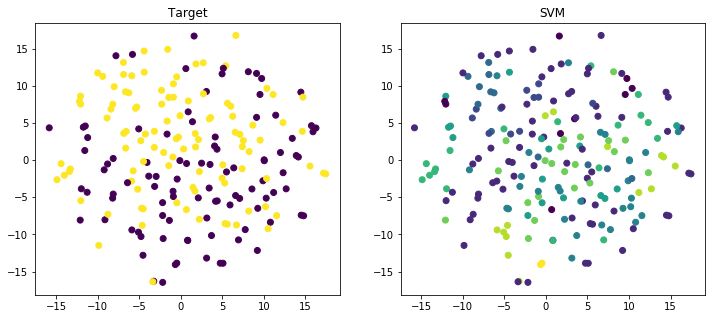

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Target')
plt.scatter(X_emb[:, 0], X_emb[:, 1], c=y_test)

plt.subplot(122)
plt.title('SVM')
plt.scatter(X_emb[:, 0], X_emb[:, 1], c=y_pred)

Попробуем обучить другие классификаторы

In [21]:
# TODO
# AffinityPropagation
# DBSCAN